In [1]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry
from minigpt4.conversation.conversation import Chat, CONV_VISION

# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *
from PIL import Image

In [2]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional

@dataclass
class NBArgs:
    cfg_path: str
    gpu_id: int = 1
    options: Optional[str] = None

In [3]:
cfg = Config(NBArgs('./eval_configs/minigpt4_eval.yaml'))

In [4]:
vis_processor_cfg = cfg.datasets_cfg.cc_sbu_align.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

In [5]:
cfg.model_cfg['llama_model'] = ''

In [6]:
model_config = cfg.model_cfg
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:1')

Loading VIT
Loading VIT Done
Loading Q-Former
Loading Q-Former Done
Loading LLAMA
Skipped LLAMA
Loading LLAMA Done
Load 4 training prompts
Prompt Example 
###Human: <Img><ImageHere></Img> Could you describe the contents of this image for me? ###Assistant: 
Load BLIP2-LLM Checkpoint: pretrained_minigpt4.pth


In [7]:
def upload_img(image):
    if isinstance(image, str):  # is a image path
        raw_image = Image.open(image).convert('RGB')
        image = vis_processor(raw_image).unsqueeze(0).to(model.device)
    elif isinstance(image, Image.Image):
        raw_image = image
        image = vis_processor(raw_image).unsqueeze(0).to(model.device)
    elif isinstance(image, torch.Tensor):
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        image = image.to(model.device)

    image_emb, _ = model.encode_img(image)
    return image_emb

In [8]:
from IPython.display import Image as DisplayImage, display
import struct

def savesp(img, f):
    emb = upload_img(img)
    emb = emb.detach().cpu().numpy()
    display(DisplayImage(img))
    print(f)
    with open(f,'wb') as bf:
        c, ntok, edim = emb.shape
        assert(c == 1)
        bf.write(struct.pack('i', ntok))
        bf.write(struct.pack('i', edim))
        for ti in range(ntok):
            for wi in range(edim):
                bf.write(struct.pack('f', emb[0, ti, wi]))

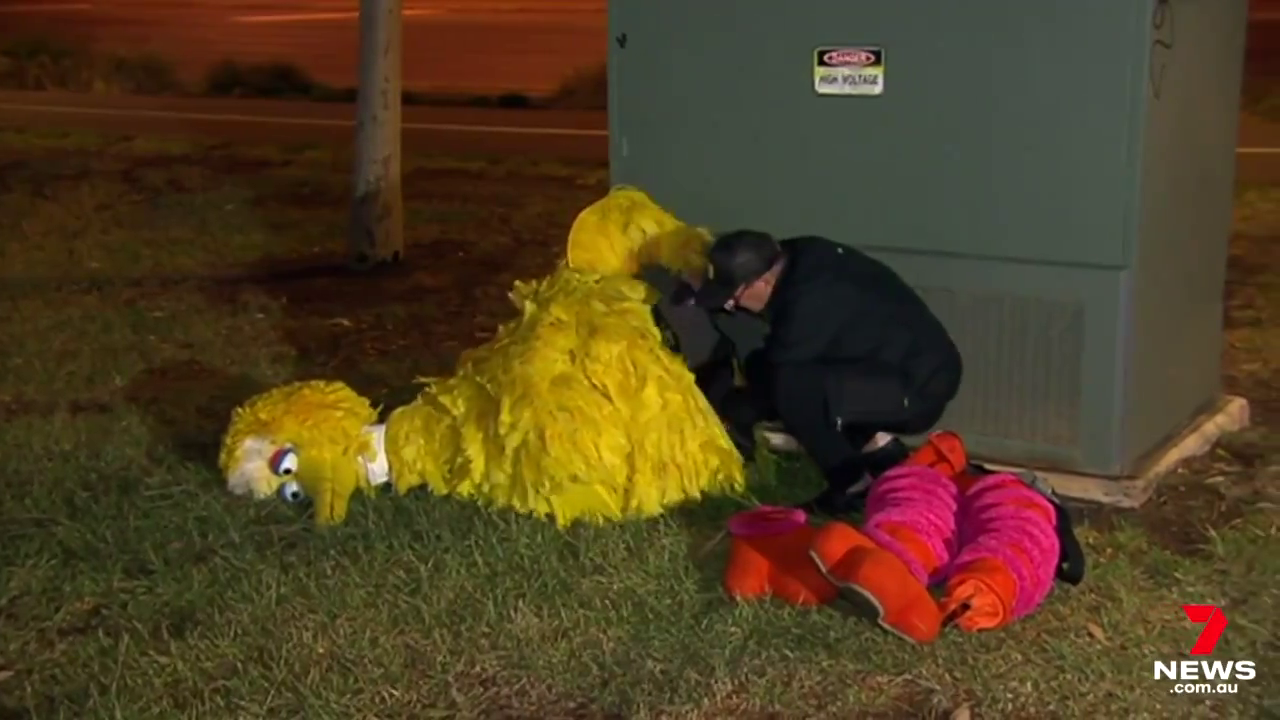

./bigbird.bin


In [13]:
savesp('/mnt/c/Users/apage/Pictures/vlcsnap-2021-04-24-03h15m26s365.png', './bigbird.bin')